In [1]:
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    RobustScaler,
)

# 이상치 탐지 추정기를 생성하는 함수를 정의합니다. 이 함수는 모델 이름, 범주형 컬럼, 각 모델의 키워드 인자를 받습니다.
def make_estimator(name, categorical_columns=None, iforest_kw=None, lof_kw=None):
    """Create an outlier detection estimator based on its name."""
    if name == "LOF":
        outlier_detector = LocalOutlierFactor(**(lof_kw or {}))
        if categorical_columns is None:
            preprocessor = RobustScaler()
        else:
            preprocessor = ColumnTransformer(
                transformers=[("categorical", OneHotEncoder(), categorical_columns)],
                remainder=RobustScaler(),
            )
    else:  # name == "IForest"
        outlier_detector = IsolationForest(**(iforest_kw or {}))
        if categorical_columns is None:
            preprocessor = None
        else:
            ordinal_encoder = OrdinalEncoder(
                handle_unknown="use_encoded_value", unknown_value=-1
            )
            preprocessor = ColumnTransformer(
                transformers=[
                    ("categorical", ordinal_encoder, categorical_columns),
                ],
                remainder="passthrough",
            )

    return make_pipeline(preprocessor, outlier_detector)

In [3]:
from time import perf_counter

# 모델 학습 및 예측 시간을 측정하는 함수를 정의합니다.
def fit_predict(estimator, X):
    tic = perf_counter()
    if estimator[-1].__class__.__name__ == "LocalOutlierFactor":
        estimator.fit(X)
        y_pred = estimator[-1].negative_outlier_factor_
    else:  # "IsolationForest"
        y_pred = estimator.fit(X).decision_function(X)
    toc = perf_counter()
    print(f"Duration for {model_name}: {toc - tic:.2f} s")
    return y_pred

In [4]:
import numpy as np

from sklearn.datasets import fetch_kddcup99
from sklearn.model_selection import train_test_split

X, y = fetch_kddcup99(
    subset="SA", percent10=True, random_state=42, return_X_y=True, as_frame=True
)
y = (y != b"normal.").astype(np.int32)
X, _, y, _ = train_test_split(X, y, train_size=0.1, stratify=y, random_state=42)

n_samples, anomaly_frac = X.shape[0], y.mean()
print(f"{n_samples} datapoints with {y.sum()} anomalies ({anomaly_frac:.02%})")

10065 datapoints with 338 anomalies (3.36%)


In [5]:
y_true = {}
y_pred = {"LOF": {}, "IForest": {}}
model_names = ["LOF", "IForest"]
cat_columns = ["protocol_type", "service", "flag"]

y_true["KDDCup99 - SA"] = y
for model_name in model_names:
    model = make_estimator(
        name=model_name,
        categorical_columns=cat_columns,
        lof_kw={"n_neighbors": int(n_samples * anomaly_frac)},
        iforest_kw={"random_state": 42},
    )
    y_pred[model_name]["KDDCup99 - SA"] = fit_predict(model, X)

Duration for LOF: 0.39 s
Duration for IForest: 0.20 s


In [6]:
from sklearn.datasets import fetch_covtype

X, y = fetch_covtype(return_X_y=True, as_frame=True)
s = (y == 2) + (y == 4)
X = X.loc[s]
y = y.loc[s]
y = (y != 2).astype(np.int32)

X, _, y, _ = train_test_split(X, y, train_size=0.05, stratify=y, random_state=42)
X_forestcover = X 

n_samples, anomaly_frac = X.shape[0], y.mean()
print(f"{n_samples} datapoints with {y.sum()} anomalies ({anomaly_frac:.02%})")

14302 datapoints with 137 anomalies (0.96%)


In [7]:
y_true["forestcover"] = y
for model_name in model_names:
    model = make_estimator(
        name=model_name,
        lof_kw={"n_neighbors": int(n_samples * anomaly_frac)},
        iforest_kw={"random_state": 42},
    )
    y_pred[model_name]["forestcover"] = fit_predict(model, X)

Duration for LOF: 0.49 s
Duration for IForest: 0.15 s


/opt/conda/lib/python3.10/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


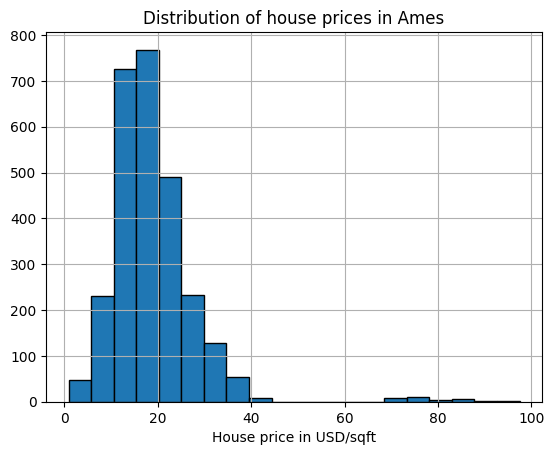

In [8]:
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml

X, y = fetch_openml(name="ames_housing", version=1, return_X_y=True, as_frame=True)
y = y.div(X["Lot_Area"])

X["Misc_Feature"] = X["Misc_Feature"].cat.add_categories("NoInfo").fillna("NoInfo")
X["Mas_Vnr_Type"] = X["Mas_Vnr_Type"].cat.add_categories("NoInfo").fillna("NoInfo")

X.drop(columns="Lot_Area", inplace=True)
mask = (y < 40) | (y > 70)
X = X.loc[mask]
y = y.loc[mask]
y.hist(bins=20, edgecolor="black")
plt.xlabel("House price in USD/sqft")
_ = plt.title("Distribution of house prices in Ames")

In [9]:
y = (y > 70).astype(np.int32)

n_samples, anomaly_frac = X.shape[0], y.mean()
print(f"{n_samples} datapoints with {y.sum()} anomalies ({anomaly_frac:.02%})")

2714 datapoints with 30 anomalies (1.11%)


In [10]:
from sklearn.compose import make_column_selector as selector

categorical_columns_selector = selector(dtype_include="category")
cat_columns = categorical_columns_selector(X)

y_true["ames_housing"] = y
for model_name in model_names:
    model = make_estimator(
        name=model_name,
        categorical_columns=cat_columns,
        lof_kw={"n_neighbors": int(n_samples * anomaly_frac)},
        iforest_kw={"random_state": 42},
    )
    y_pred[model_name]["ames_housing"] = fit_predict(model, X)

Duration for LOF: 4.45 s
Duration for IForest: 0.18 s


In [11]:
X, y = fetch_openml(name="cardiotocography", version=1, return_X_y=True, as_frame=False)
X_cardiotocography = X  
s = y == "3"
y = s.astype(np.int32)

n_samples, anomaly_frac = X.shape[0], y.mean()
print(f"{n_samples} datapoints with {y.sum()} anomalies ({anomaly_frac:.02%})")

/opt/conda/lib/python3.10/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


2126 datapoints with 53 anomalies (2.49%)


In [12]:
y_true["cardiotocography"] = y
for model_name in model_names:
    model = make_estimator(
        name=model_name,
        lof_kw={"n_neighbors": int(n_samples * anomaly_frac)},
        iforest_kw={"random_state": 42},
    )
    y_pred[model_name]["cardiotocography"] = fit_predict(model, X)

Duration for LOF: 0.04 s
Duration for IForest: 0.09 s


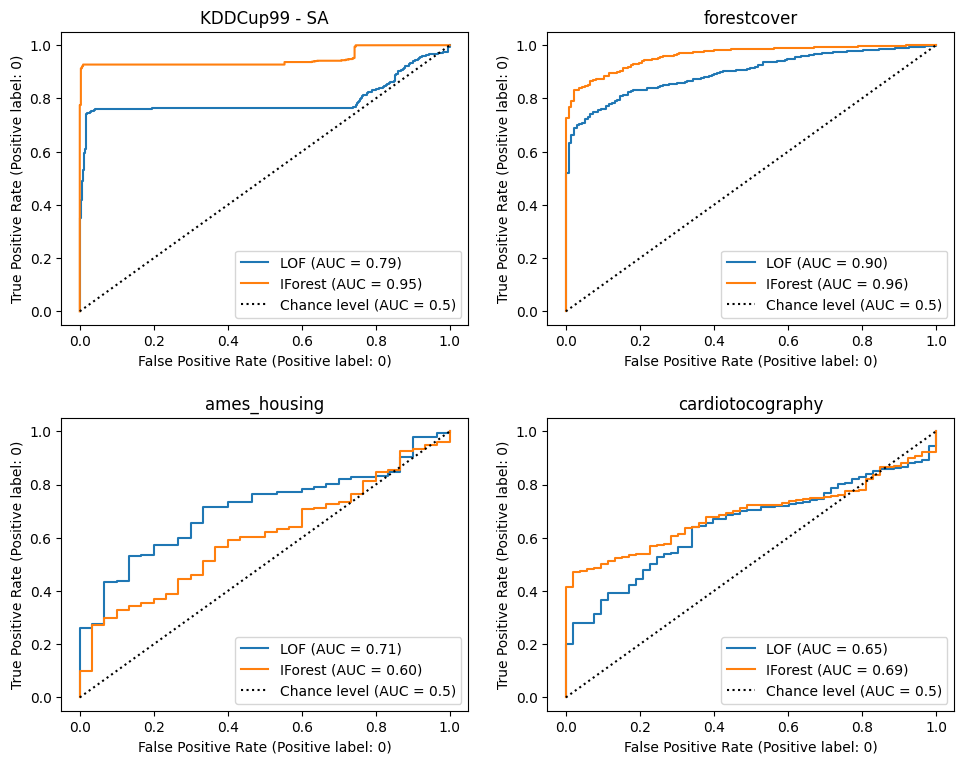

In [13]:
import math

from sklearn.metrics import RocCurveDisplay

cols = 2
pos_label = 0  
datasets_names = y_true.keys()
rows = math.ceil(len(datasets_names) / cols)

fig, axs = plt.subplots(nrows=rows, ncols=cols, squeeze=False, figsize=(10, rows * 4))

for ax, dataset_name in zip(axs.ravel(), datasets_names):
    for model_idx, model_name in enumerate(model_names):
        display = RocCurveDisplay.from_predictions(
            y_true[dataset_name],
            y_pred[model_name][dataset_name],
            pos_label=pos_label,
            name=model_name,
            ax=ax,
            plot_chance_level=(model_idx == len(model_names) - 1),
            chance_level_kw={"linestyle": ":"},
        )
    ax.set_title(dataset_name)
_ = plt.tight_layout(pad=2.0)  # spacing between subplots

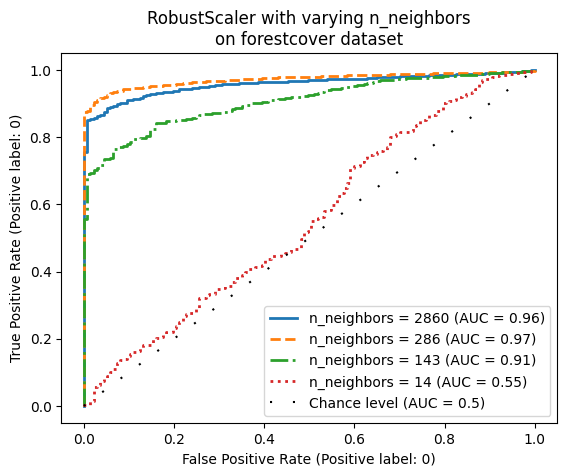

In [14]:
X = X_forestcover
y = y_true["forestcover"]

n_samples = X.shape[0]
n_neighbors_list = (n_samples * np.array([0.2, 0.02, 0.01, 0.001])).astype(np.int32)
model = make_pipeline(RobustScaler(), LocalOutlierFactor())

linestyles = ["solid", "dashed", "dashdot", ":", (5, (10, 3))]

fig, ax = plt.subplots()
for model_idx, (linestyle, n_neighbors) in enumerate(zip(linestyles, n_neighbors_list)):
    model.set_params(localoutlierfactor__n_neighbors=n_neighbors)
    model.fit(X)
    y_pred = model[-1].negative_outlier_factor_
    display = RocCurveDisplay.from_predictions(
        y,
        y_pred,
        pos_label=pos_label,
        name=f"n_neighbors = {n_neighbors}",
        ax=ax,
        plot_chance_level=(model_idx == len(n_neighbors_list) - 1),
        chance_level_kw={"linestyle": (0, (1, 10))},
        linestyle=linestyle,
        linewidth=2,
    )
_ = ax.set_title("RobustScaler with varying n_neighbors\non forestcover dataset")

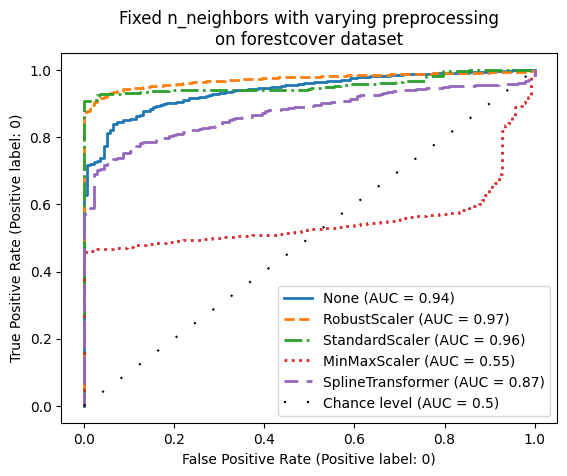

In [15]:
from sklearn.preprocessing import MinMaxScaler, SplineTransformer, StandardScaler

preprocessor_list = [
    None,
    RobustScaler(),
    StandardScaler(),
    MinMaxScaler(),
    SplineTransformer(),
]
expected_anomaly_fraction = 0.02
lof = LocalOutlierFactor(n_neighbors=int(n_samples * expected_anomaly_fraction))

fig, ax = plt.subplots()
for model_idx, (linestyle, preprocessor) in enumerate(
    zip(linestyles, preprocessor_list)
):
    model = make_pipeline(preprocessor, lof)
    model.fit(X)
    y_pred = model[-1].negative_outlier_factor_
    display = RocCurveDisplay.from_predictions(
        y,
        y_pred,
        pos_label=pos_label,
        name=str(preprocessor).split("(")[0],
        ax=ax,
        plot_chance_level=(model_idx == len(preprocessor_list) - 1),
        chance_level_kw={"linestyle": (0, (1, 10))},
        linestyle=linestyle,
        linewidth=2,
    )
_ = ax.set_title("Fixed n_neighbors with varying preprocessing\non forestcover dataset")

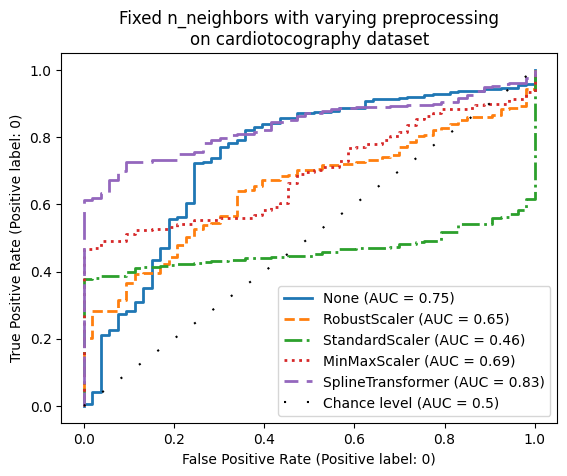

In [16]:
X = X_cardiotocography
y = y_true["cardiotocography"]

n_samples, expected_anomaly_fraction = X.shape[0], 0.025
lof = LocalOutlierFactor(n_neighbors=int(n_samples * expected_anomaly_fraction))

fig, ax = plt.subplots()
for model_idx, (linestyle, preprocessor) in enumerate(
    zip(linestyles, preprocessor_list)
):
    model = make_pipeline(preprocessor, lof)
    model.fit(X)
    y_pred = model[-1].negative_outlier_factor_
    display = RocCurveDisplay.from_predictions(
        y,
        y_pred,
        pos_label=pos_label,
        name=str(preprocessor).split("(")[0],
        ax=ax,
        plot_chance_level=(model_idx == len(preprocessor_list) - 1),
        chance_level_kw={"linestyle": (0, (1, 10))},
        linestyle=linestyle,
        linewidth=2,
    )
ax.set_title(
    "Fixed n_neighbors with varying preprocessing\non cardiotocography dataset"
)
plt.show()